In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

from mc_agent import MLWrapper, CostSurface, MCAgent # custom ML classes

In [2]:
# Load the pre-processed cost surfaces
cost_surface = CostSurface()
cost_surface.load_rasters('./cost_surfaces/raw_cost_10km_aea')

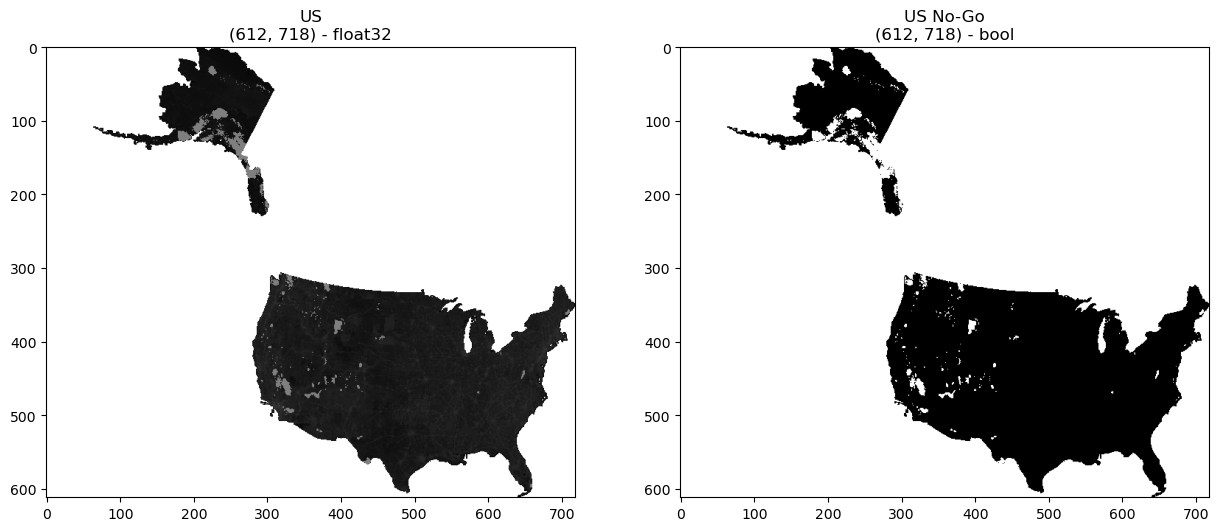

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ax[0].set_title('US\n{} - {}'.format(cost_surface.cost.shape, cost_surface.cost.dtype))
ax[0].imshow(cost_surface.cost, cmap='gray')

ax[1].imshow(cost_surface.no_go, cmap='gray')
ax[1].set_title('US No-Go\n{} - {}'.format(cost_surface.no_go.shape, cost_surface.no_go.dtype))

plt.show()

In [4]:
def normalize(arr, high=1, low=0):
    norm = (high-low)*(arr - arr.min())/(arr.max() - arr.min()) + low
    return norm

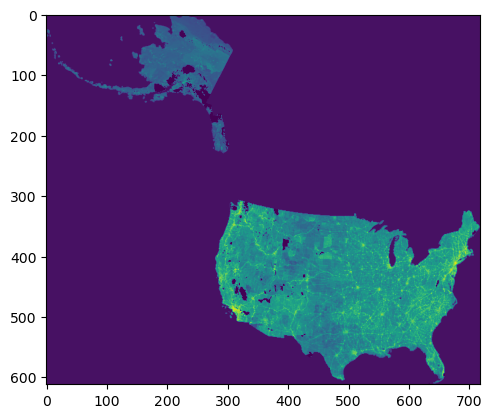

In [5]:
# For comparison take a look at the original raster
path = './cost_surfaces/raw_cost_10km_aea/cost_10km_aea.tif'
ds = rasterio.open(path)
original = ds.read(1)
image = original.copy()
# original = np.array(img)
# clip = original[:400,:750]
# clip[clip==np.inf] = 0
# clip[clip==-1] = 0
# norm = nomrmalize(clip)
# print(norm.shape)
# print(norm.max())
# print(norm.min())
image[image<-1]=0
plt.imshow(image)
plt.show()

In [6]:
def generate_locations(no_go, start, target, rng, max_distance=50):
    """
    Can be used to generate valid start and target locations
    """

    while start is None:
        shape = no_go.shape
        y = rng.integers(0, shape[0], 1)[0]
        x = rng.integers(0, shape[1], 1)[0]
        if not no_go[y, x]:
            start = (y, x)
    
    while target is None:
        shape = no_go.shape
        y = rng.integers(
            max(0, start[0]-max_distance), 
            min(shape[0], start[0] + max_distance),
            1
        )
        y = y[0]

        x = rng.integers(
            max(0, start[1]-max_distance), 
            min(shape[1], start[1] + max_distance),
            1
        )
        x = x[0]

        if not no_go[y, x]:
            target = (y, x)

    return start, target

In [7]:
rng = np.random.default_rng(seed=42)
start, target = generate_locations(cost_surface.no_go, start=None, target=None, rng=rng, max_distance=100)

In [8]:
print(start)
print(target)

(400, 315)
(386, 386)


In [9]:
def draw_circle(img, start, target, radius):
    """
    Creates a three channel colored image with start and target locations.
    """
    r = img.copy()
    g = np.zeros(img.shape)
    b = np.zeros(img.shape)

    y, x = np.mgrid[:img.shape[0], :img.shape[1]]
    
    circle = (y-start[0])**2 + (x-start[1])**2
    b[circle < radius**2] = 1

    circle = (y-target[0])**2 + (x-target[1])**2
    g[circle < radius**2] = 1

    r = np.expand_dims(r, axis=2)
    g = np.expand_dims(g, axis=2)
    b = np.expand_dims(b, axis=2)

    new_img = np.concatenate((r,g,b), axis=2)

    return new_img

def draw_circle(img, center, radius):
    """
    Modifies the specified img in place by drawing a circle on it.
    """
    img = img.copy()
    y, x = np.mgrid[:img.shape[0], :img.shape[1]]
    circle = (y-center[0])**2 + (x-center[1])**2
    img[circle < radius**2] = 1

    return img

def visualize(cost_surface, agent, target, locations=[], path=[], radius=5):
    
    # Build observation
    shape = (3, *cost_surface.shape)
    obs = np.zeros(shape, dtype=np.float32)

    # Set red channel equal to the given cost surface
    obs[0,:,:] = cost_surface.copy()

    # Set green channel to target location
    obs[1,:,:] = draw_circle(
        np.zeros((cost_surface.shape), dtype=np.float32), 
        center=target,
        radius=radius
        )
    
    # Set blue channel to agent location
    obs[2,:,:] = draw_circle(
        np.zeros((cost_surface.shape), dtype=np.float32), 
        center=agent,
        radius=radius
        )
    
    # Record path through the surface
    if path:
        all_y, all_x = zip(*path)
        obs[:, all_y, all_x] = 1

    elif locations:
        all_y, all_x = zip(*locations)
        obs[:, all_y, all_x] = 1
        
    return obs

(3, 612, 718)
float32


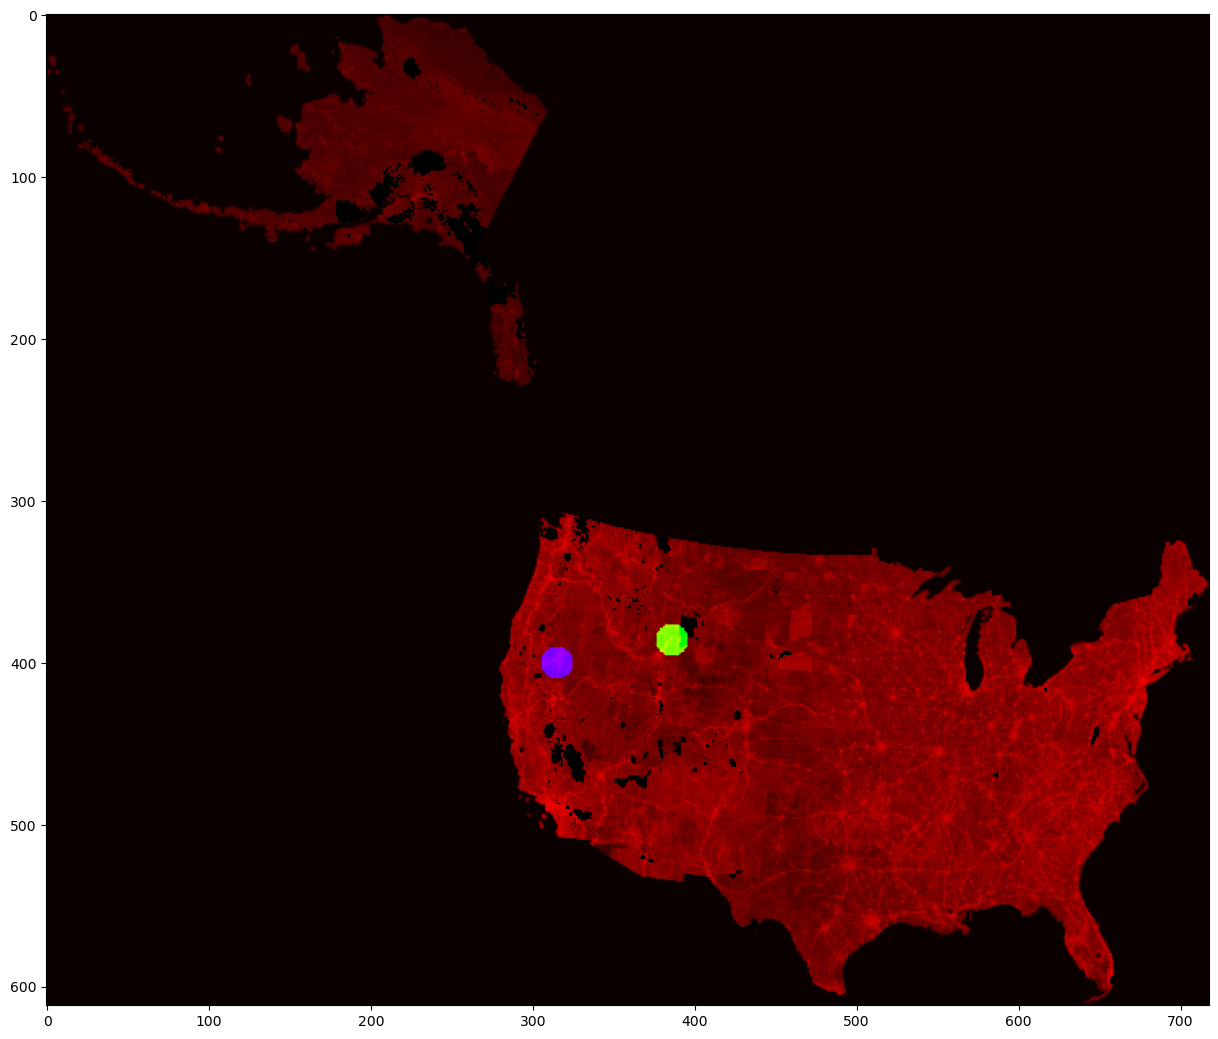

In [10]:
org_raster = visualize(normalize(image.copy()), start, target, radius=10)
print(org_raster.shape)
print(org_raster.dtype)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(np.moveaxis(org_raster, 0, -1))
plt.show()

(3, 612, 718)
float32


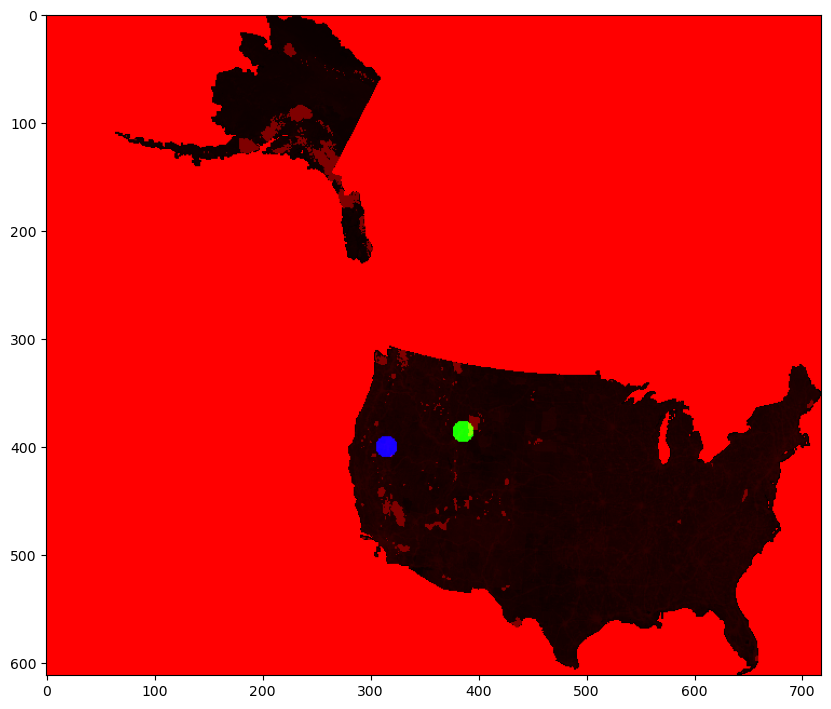

In [11]:
processed_raster = visualize(cost_surface.cost.copy(), start, target, radius=10)
print(processed_raster.shape)
print(processed_raster.dtype)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(np.moveaxis(processed_raster, 0, -1))
plt.show()

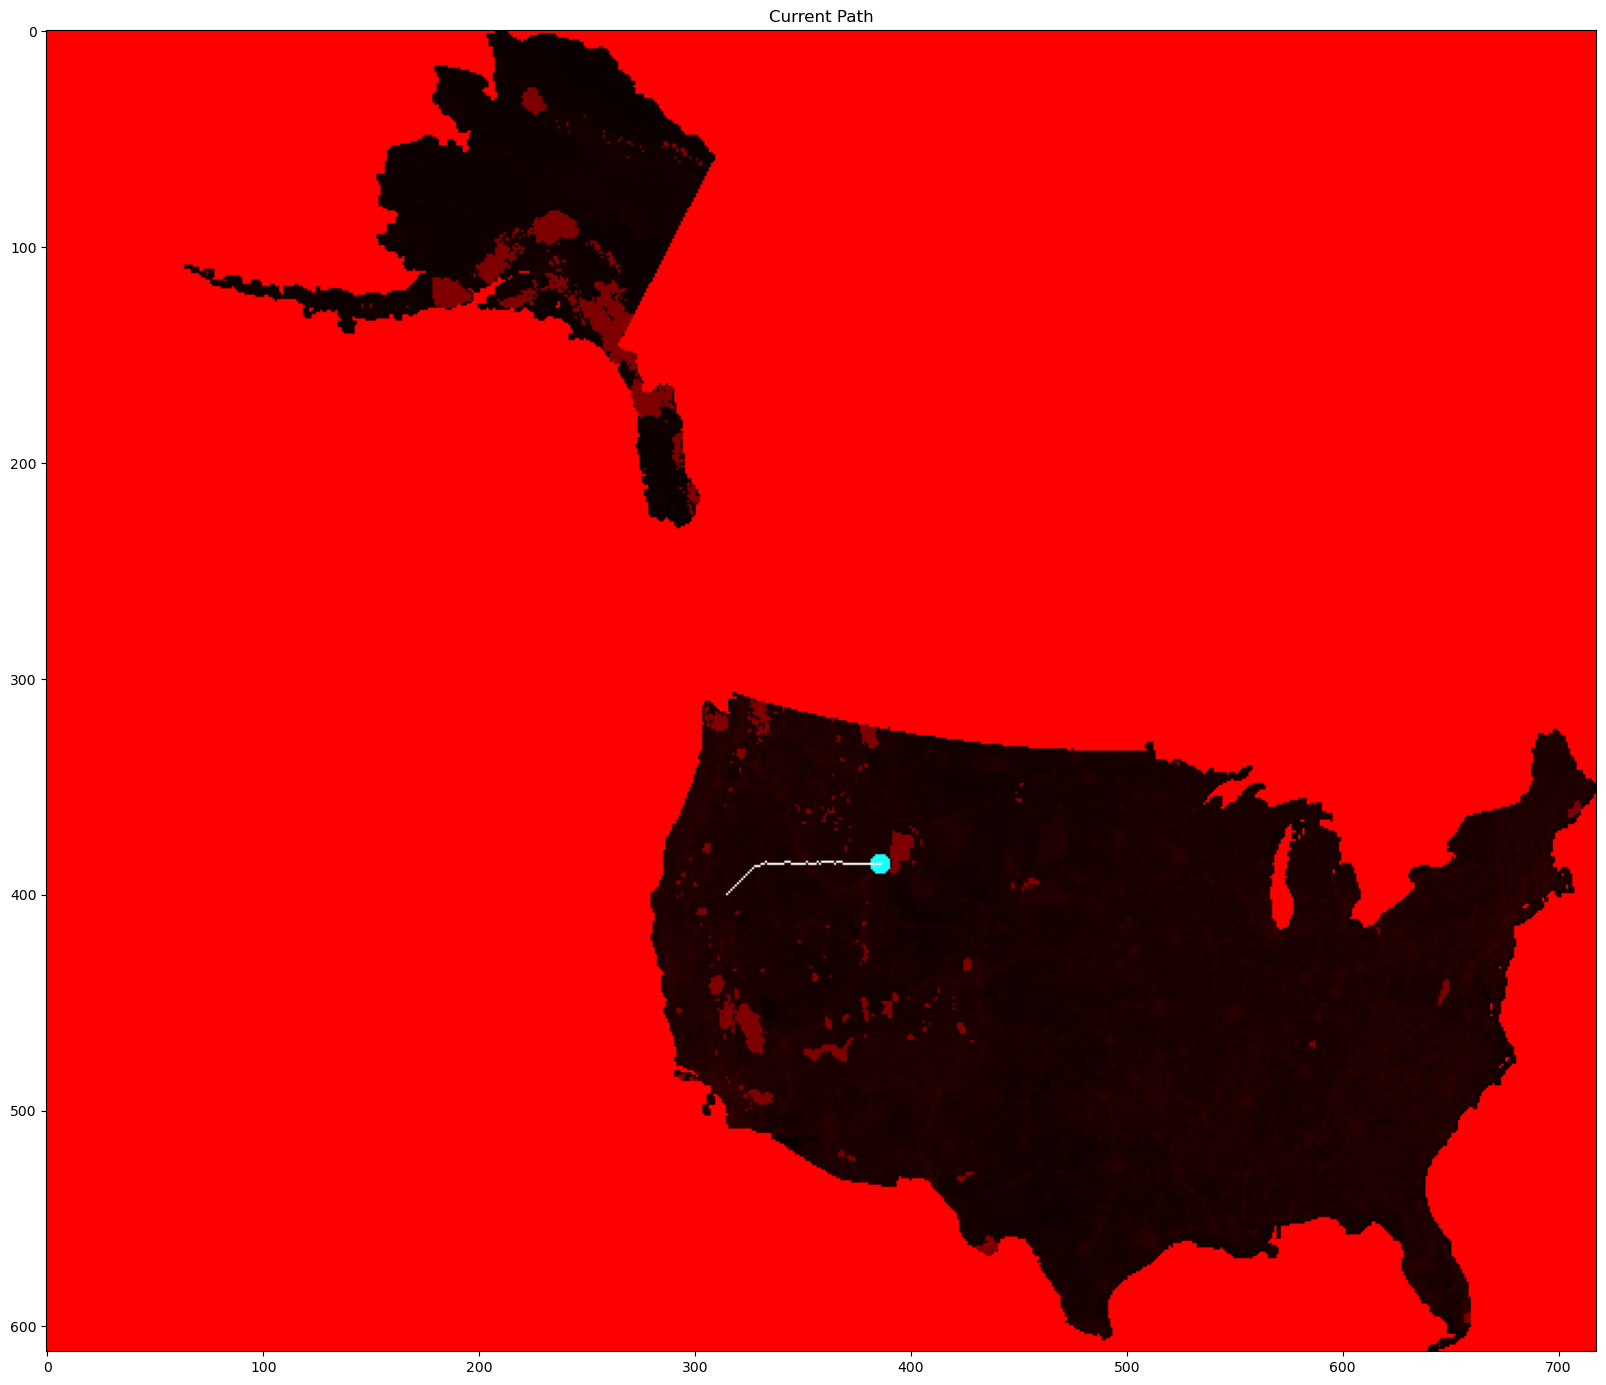

In [12]:
# Define agent which makes routing choices
agent = MCAgent(100, 1)
path = agent.route(
    cost_surface=cost_surface.cost,
    start=list(start),
    target=list(target),
    show_viz=True
    )

Path generated


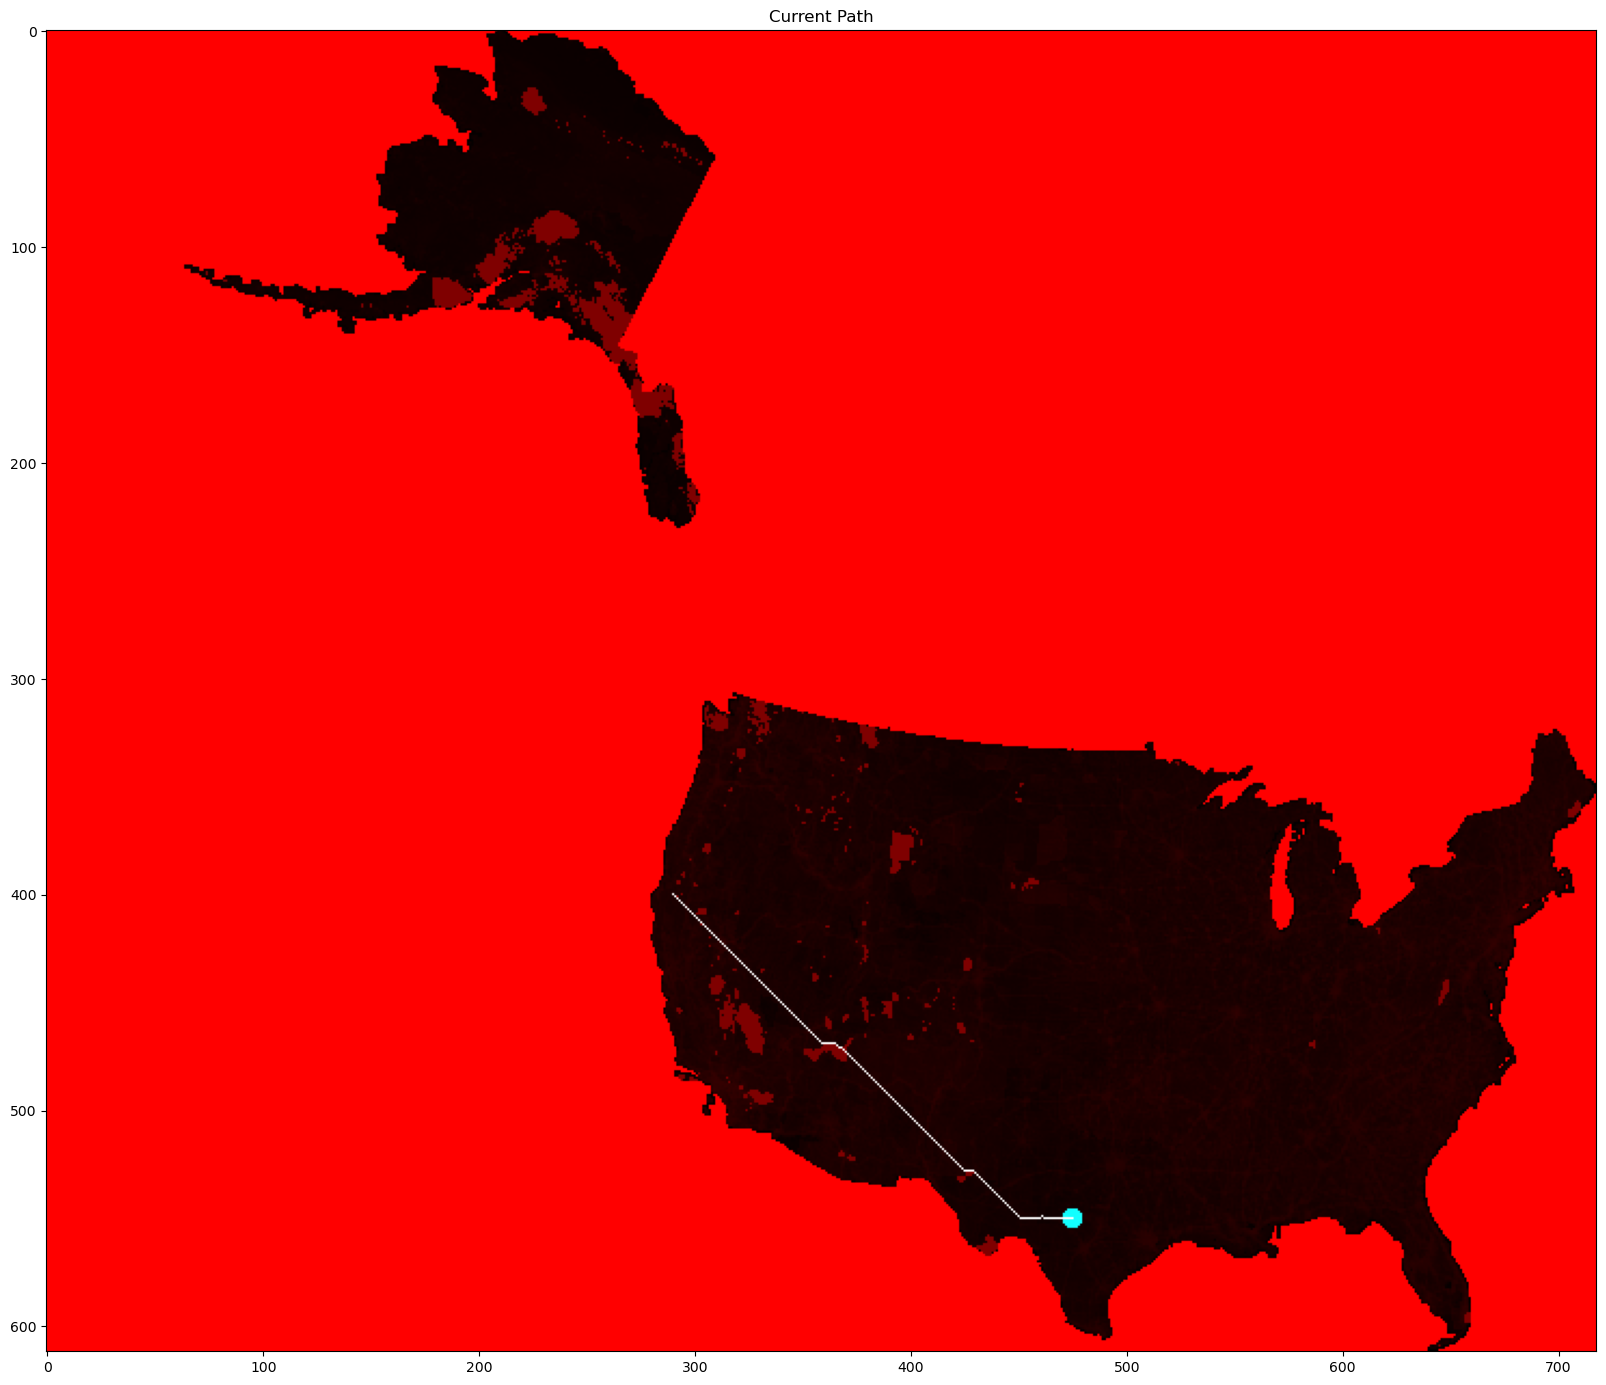

In [13]:
sf = (382, 280)
sa = (526, 343)

ca = [400, 290]
tx = [550, 475]

ml_wrapper = MLWrapper()
# lucy_path, path_using_wrapper = ml_wrapper.route(org_start, org_target)
lucy_path, path_using_wrapper = ml_wrapper.route(ca, tx, show_viz=True)

In [14]:
assert path == path_using_wrapper

AssertionError: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


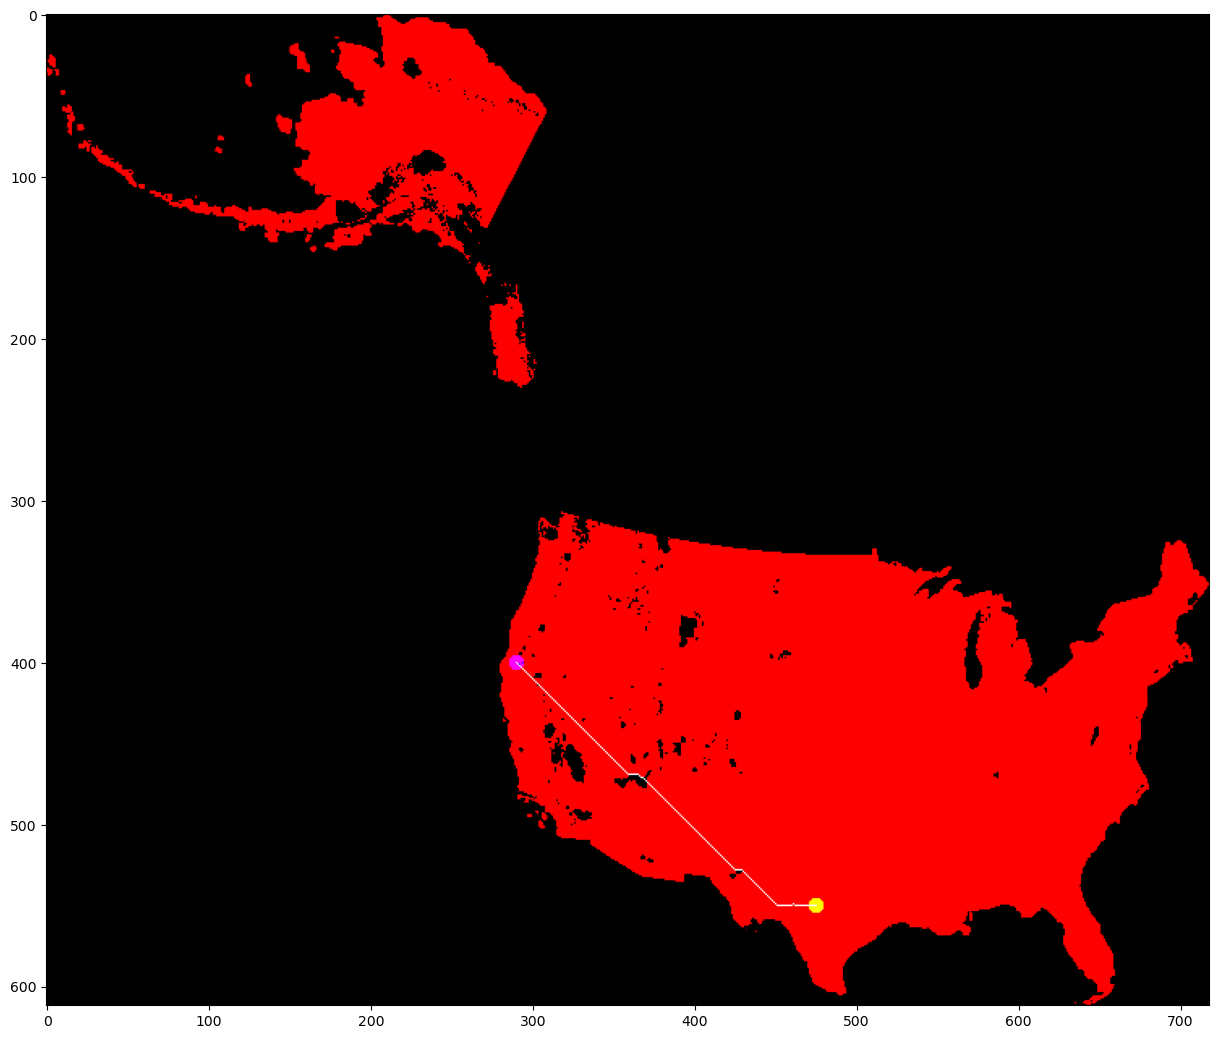

In [ ]:
sf = [400, 290]
sa = [550, 475]
obs = visualize(image, sf, sa, path=lucy_path)

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(np.moveaxis(obs, 0, -1))
plt.show()

In [ ]:
path = [
    (280, 382),
    (281, 383),
    (282, 384),
    (283, 385),
    (284, 386),
    (285, 387),
    (286, 388),
    (287, 389),
    (288, 390),
    (289, 391),
    (290, 392),
    (291, 393),
    (292, 394),
    (293, 395),
    (294, 396),
    (295, 397),
    (296, 398),
    (297, 399),
    (298, 400),
    (299, 401),
    (300, 402),
    (301, 403),
    (302, 404),
    (303, 405),
    (304, 406),
    (305, 407),
    (306, 408),
    (307, 409),
    (308, 410),
    (309, 411),
    (310, 412),
    (311, 413),
    (312, 414),
    (313, 415),
    (314, 416),
    (315, 417),
    (316, 418),
    (317, 419),
    (318, 420),
    (319, 421),
    (320, 422),
    (321, 423),
    (322, 424),
    (323, 425),
    (324, 426),
    (325, 427),
    (326, 428),
    (327, 429),
    (328, 430),
    (329, 431),
    (330, 432),
    (331, 433),
    (332, 434),
    (333, 435),
    (334, 436),
    (335, 437),
    (336, 438),
    (337, 439),
    (338, 440),
    (339, 441),
    (340, 442),
    (341, 443),
    (341, 444),
    (341, 445),
    (342, 446),
    (342, 447),
    (342, 448),
    (341, 449),
    (341, 450),
    (341, 451),
    (342, 452),
    (342, 453),
    (342, 454),
    (342, 455),
    (342, 456),
    (342, 457),
    (343, 458),
    (342, 459),
    (342, 460),
    (342, 461),
    (342, 462),
    (342, 463),
    (343, 464),
    (343, 465),
    (344, 466),
    (344, 467),
    (344, 468),
    (343, 469),
    (343, 470),
    (343, 471),
    (343, 472),
    (343, 473),
    (343, 474),
    (343, 475),
    (343, 476),
    (343, 477),
    (343, 478),
    (343, 479),
    (342, 480),
    (342, 481),
    (342, 482),
    (342, 483),
    (342, 484),
    (342, 485),
    (342, 486),
    (342, 487),
    (343, 488),
    (343, 489),
    (343, 490),
    (343, 491),
    (343, 492),
    (342, 493),
    (342, 494),
    (342, 495),
    (343, 496),
    (343, 497),
    (343, 498),
    (343, 499),
    (343, 500),
    (343, 501),
    (343, 502),
    (344, 503),
    (343, 504),
    (343, 505),
    (343, 506),
    (343, 507),
    (343, 508),
    (343, 509),
    (343, 510),
    (343, 511),
    (343, 512),
    (343, 513),
    (343, 514),
    (343, 515),
    (343, 516),
    (343, 517),
    (343, 518),
    (343, 519),
    (343, 520),
    (343, 521),
    (343, 522),
    (343, 523),
    (343, 524),
    (343, 525),
    (343, 526)
    ]
